# BGG Data Scraping using BeautifulSoup and Selenium

# Main Functions and Cells for Scrapping

##########################################################

**IMPORTANT** Use virtual environment --> *investing* 

##########################################################

In [1]:
import pandas as pd
import requests

## Getting the list of URLS from the official CSV 
## https://gitlab.com/recommend.games/bgg-ranking-historicals/-/tree/master?ref_type=heads

df = pd.read_csv('BGGbaseData/FullBGGData_2025-03-25.csv', sep=',', header=0)
df.head()

,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,224517,Brass: Birmingham,2018,1,8.58,8.404,51044,/boardgame/224517/brass-birmingham,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...
1,161936,Pandemic Legacy: Season 1,2015,2,8.52,8.367,55240,/boardgame/161936/pandemic-legacy-season-1,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...
2,342942,Ark Nova,2021,3,8.53,8.344,50991,/boardgame/342942/ark-nova,https://cf.geekdo-images.com/SoU8p28Sk1s8MSvoM...
3,174430,Gloomhaven,2017,4,8.57,8.330,64481,/boardgame/174430/gloomhaven,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...
4,233078,Twilight Imperium: Fourth Edition,2017,5,8.58,8.230,25712,/boardgame/233078/twilight-imperium-fourth-edi...,https://cf.geekdo-images.com/_Ppn5lssO5OaildSE...


Save the URLs in a list

In [2]:
baseurl = 'https://boardgamegeek.com'
listurls = df.URL.to_list()
listurls = [baseurl + url for url in listurls]
print(f'Number of URLs: {len(listurls)}')
print()
listurls[:5]

Number of URLs: 28153



['https://boardgamegeek.com/boardgame/224517/brass-birmingham',
 'https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1',
 'https://boardgamegeek.com/boardgame/342942/ark-nova',
 'https://boardgamegeek.com/boardgame/174430/gloomhaven',
 'https://boardgamegeek.com/boardgame/233078/twilight-imperium-fourth-edition']

## Testing Selenium Methods in One URL

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import re

service = Service('/Users/juanito/Applications/chromedriver-mac-arm64/chromedriver')
driver = webdriver.Chrome(service=service)
driver.get('https://boardgamegeek.com/boardgame/264164/night-of-the-living-dead-a-zombicide-game/credits')

# Wait for at least one mechanic link to appear in the DOM.
wait = WebDriverWait(driver, 10)
wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='/boardgamemechanic/']")))

html_content = driver.page_source
driver.quit()

soup = BeautifulSoup(html_content, "html.parser")
# Find all <a> tags whose href attribute contains "/boardgamemechanic/"
mechanics_links = soup.find_all("a", href=re.compile("/boardgamemechanic/"))
mechanics_list = [link.get_text(strip=True) for link in mechanics_links]

print("Mechanics extracted via Selenium:")
print("\n".join(mechanics_list))

Mechanics extracted via Selenium:
Action Points
Cooperative Game
Dice Rolling
Modular Board
Scenario / Mission / Campaign Game
Variable Player Powers


In [26]:
import json
import re

response = requests.get('https://boardgamegeek.com/boardgame/266507/clank-legacy-acquisitions-incorporated')
response.raise_for_status()
html_content = response.content

soup = BeautifulSoup(html_content, "html.parser")
json_data_match = re.search(r'GEEK\.geekitemPreload = ({.*?});', str(soup))
json_data = json.loads(json_data_match.group(1))
stats = json_data.get('item', {}).get('stats', {})
print(stats)
json_data.get('item', {}).get('links', {}).get('boardgamedesigner', [])
#soup

{'usersrated': '10328', 'average': '8.52034', 'baverage': '7.94663', 'stddev': '1.43947', 'avgweight': '2.7389', 'numweights': '157', 'numgeeklists': '1086', 'numtrading': '109', 'numwanting': '646', 'numwish': '6435', 'numowned': '18086', 'numprevowned': '1542', 'numcomments': '1610', 'numwishlistcomments': '533', 'numhasparts': '4', 'numwantparts': '2', 'numpreordered': '207', 'numwanttoplay': '3213', 'numwanttobuy': '1735', 'views': '1265109', 'playmonth': '2025-04', 'numplays': '60737', 'numplays_month': '279', 'numfans': 1028}


[{'name': 'Andy Clautice',
  'sortindex': '6',
  'objecttype': 'person',
  'objectid': '37507',
  'primarylink': 0,
  'itemstate': 'approved',
  'href': '/boardgamedesigner/37507/andy-clautice',
  'canonical_link': 'https://boardgamegeek.com/boardgamedesigner/37507/andy-clautice'},
 {'name': 'Paul Dennen',
  'sortindex': '6',
  'objecttype': 'person',
  'objectid': '92370',
  'primarylink': 0,
  'itemstate': 'approved',
  'href': '/boardgamedesigner/92370/paul-dennen',
  'canonical_link': 'https://boardgamegeek.com/boardgamedesigner/92370/paul-dennen'}]

## Functions

In [27]:
import json
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException  # ADDED: to catch timeouts
from urllib3.exceptions import ReadTimeoutError  # **ADDED: To catch read timeout errors**

# === ADDED: Function to get (or create) the Selenium driver ===
def get_selenium_driver():
    global selenium_driver
    if selenium_driver is None:
        try:
            service = Service('/Users/juanito/Applications/chromedriver-mac-arm64/chromedriver')
            selenium_driver = webdriver.Chrome(service=service)
            print("Selenium driver created.")
        except WebDriverException as e:
            print(f"Error creating Selenium driver: {e}")
    return selenium_driver

# === ADDED: Function to close the Selenium driver when done ===
def close_selenium_driver():
    global selenium_driver
    if selenium_driver is not None:
        selenium_driver.quit()
        selenium_driver = None

# === ADDED: Helper function for robust GET requests with retries ===
def robust_get(url, params=None, headers=None, retries=3, delay=2):
    for attempt in range(retries):
        try:
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()
            return response
        except requests.RequestException as e:
            print(f"Error fetching {url} on attempt {attempt+1}/{retries}: {e}")
            time.sleep(delay)
    return None

def fetch_page_content(url, headers={'User-Agent': 'Mozilla/5.0'}):
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.content
    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return None

def parse_html(html_content):
    return BeautifulSoup(html_content, "html.parser")

def extract_game_data(soup, url):
    game_data = {}
    objectid = url.split('/')[-2]

    title_tag = soup.find('title')
    title_text = title_tag.text.split('|')[0] if title_tag else 'Unknown'
    game_data['Title'] = title_text

    json_data_match = re.search(r'GEEK\.geekitemPreload = ({.*?});', str(soup))
    if json_data_match:
        try:
            json_data = json.loads(json_data_match.group(1))
            game_data['ObjectID'] = json_data['item']['objectid']
            game_data['Link'] = url
            #game_data['Rank'] = rank  # Store in dictionary 
            game_data['Rank'] = json_data['item']['rankinfo'][0]['rank']
            year_published = json_data.get('item', {}).get('yearpublished', 'Unknown')
            game_data['Year'] = year_published  # Store in dictionary        
            # Extract additional game info
            # Game designers
            designers_list = json_data.get('item', {}).get('links', {}).get('boardgamedesigner', [])
            game_data['Designers'] = [designer_item['name'] for designer_item in designers_list]

            stats = json_data.get('item', {}).get('stats', {})
            game_data['UsersRated'] = stats.get('usersrated', 'Unknown')
            game_data['AveRating'] = stats.get('average', 'Unknown')
            game_data['Baverage'] = stats.get('baverage', 'Unknown')
            game_data['StdDev'] = stats.get('stddev', 'Unknown')
            game_data['AveWeight'] = stats.get('avgweight', 'Unknown')
            game_data['NumWeights'] = stats.get('numweights', 'Unknown')
            game_data['NumPlays'] = stats.get('numplays', 'Unknown')
            linkcounts = json_data.get('item', {}).get('linkcounts', {})
            game_data['NumAwards'] = linkcounts.get('boardgamehonor', 0)
            game_data['NumGeekLists'] = stats.get('numgeeklists', 'Unknown')
            game_data['NumTrading'] = stats.get('numtrading', 'Unknown')
            game_data['NumWanting'] = stats.get('numwanting', 'Unknown')
            game_data['NumWish'] = stats.get('numwish', 'Unknown')
            game_data['NumOwned'] = stats.get('numowned', 'Unknown')
            game_data['NumComments'] = stats.get('numcomments', 'Unknown')
            game_data['NumWantToPlay'] = stats.get('numwanttoplay', 'Unknown')
            game_data['NumPlays'] = stats.get('numplays', 'Unknown')
            game_data['NumFans'] = stats.get('numfans', 'Unknown')
            game_data['Views'] = stats.get('views', 'Unknown')
            ###########################
            polls = json_data.get('item', {}).get('polls', {})
            # if polls is empty then 'NA'
            if polls == {}:
                game_data['PCountRecomm_min'] = 'NA'
                game_data['PCountRecomm_max'] = 'NA'
                game_data['PCountBest_min'] = 'NA'
                game_data['PCountBest_max'] = 'NA'
                game_data['PCount_votes'] = 'NA'
            else:
                # if empty list then 'NA'
                if polls['userplayers']['recommended'] == []:
                    game_data['PCountRecomm_min'] = 'NA'
                    game_data['PCountRecomm_max'] = 'NA'
                else:
                    game_data['PCountRecomm_min'] = polls.get('userplayers', 'Unknown')['recommended'][0]['min']
                    game_data['PCountRecomm_max'] = polls.get('userplayers', 'Unknown')['recommended'][0]['max']
                if polls['userplayers']['best'] == []:
                    game_data['PCountBest_min'] = 'NA'
                    game_data['PCountBest_max'] = 'NA'
                else:
                    game_data['PCountBest_min'] = polls.get('userplayers', 'Unknown')['best'][0]['min']
                    game_data['PCountBest_max'] = polls.get('userplayers', 'Unknown')['best'][0]['max']
                game_data['PCount_votes'] = polls.get('userplayers', 'Unknown')['totalvotes']
            ########################
            game_data['MinPlayTime'] = json_data.get('item', {}).get('minplaytime', 'NA')
            game_data['MaxPlayTime'] = json_data.get('item', {}).get('maxplaytime', 'NA')
            
            ## Download the image of the game and save it to 'images' folder
            image_url = json_data['item']['imageurl']
            image_response = requests.get(image_url)
            if image_response.status_code == 200:
                with open(f'images/{objectid}.jpg', 'wb') as f:
                    f.write(image_response.content) 

            #########################################
            ## New Mechanics Logic. Using Selenium
            MAX_SELENIUM_RETRIES = 3  # **ADDED: Maximum number of Selenium retries**
            for attempt in range(MAX_SELENIUM_RETRIES):
                try:
                    driver = get_selenium_driver()
                    driver.get(url + '/credits')
                    wait = WebDriverWait(driver, 10)
                    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "a[href*='/boardgamemechanic/']")))
                    html_content = driver.page_source
                    soup = BeautifulSoup(html_content, "html.parser")
                    # Find all <a> tags whose href attribute contains "/boardgamemechanic/"
                    mechanics_links = soup.find_all("a", href=re.compile("/boardgamemechanic/"))
                    mechanics_list = [link.get_text(strip=True) for link in mechanics_links]
                    #game_data['Mechanics'] = "\n".join(mechanics_list)
                    game_data['Mechanics'] = mechanics_list
                    break
                except (TimeoutException, WebDriverException, ReadTimeoutError) as e:  # **MODIFIED: Added ReadTimeoutError to the exceptions**
                    print(f"Error fetching mechanics on {url} on attempt {attempt+1}/{MAX_SELENIUM_RETRIES}: {e}")
                    close_selenium_driver()  # **MODIFIED: Reinitialize the driver if error occurs**
                    time.sleep(2)
                    if attempt == MAX_SELENIUM_RETRIES - 1:
                        print(f"Failed to load mechanics for {url} after {MAX_SELENIUM_RETRIES} attempts.")
                        game_data['Mechanics'] = []
            #########################################

            #html_content = driver.page_source
            #soup = BeautifulSoup(html_content, "html.parser")
            # Find all <a> tags whose href attribute contains "/boardgamemechanic/"
            #mechanics_links = soup.find_all("a", href=re.compile("/boardgamemechanic/"))
            #mechanics_list = [link.get_text(strip=True) for link in mechanics_links]
            #game_data['Mechanics'] = "\n".join(mechanics_list)
            #game_data['Mechanics'] = mechanics_list
            
            #########################################
            # OLD MECHANICS LOGIC
            #mechanics = json_data.get('item', {}).get('links', {}).get('boardgamemechanic', [])
            #mechstring = ''
            #for i, mech in enumerate(mechanics):
            #    mechstring += mech['name']
            #    if i < len(mech)-1:
            #        mechstring += '\n'
            #game_data['Mechanics'] = mechstring          
            
            # Extract game expansions, save as a list of names
            expansions = json_data.get('item', {}).get('links', {}).get('boardgameexpansion', [])
            list_expansions = []
            for i, exp in enumerate(expansions):
                list_expansions.append(exp['name'])
            game_data['Expansions'] = list_expansions

            # Extract all Categories as a list
            all_categories = json_data.get('item', {}).get('links', {}).get('boardgamecategory', [])
            game_data['Categories'] = [cat_item['name'] for cat_item in all_categories]

            rankinfo = json_data.get('item', {}).get('rankinfo', [])
            for i, rinf in enumerate(rankinfo):
                if rinf['prettyname'] != 'Board Game Rank':
                    game_data['GameCategory_'+str(i)] = rinf['veryshortprettyname']
                    game_data['RankCategory_'+str(i)] = rinf['rank']
                    game_data['ScoreCategory_'+str(i)] = rinf['baverage']          
        except json.JSONDecodeError as e:
            print(f"JSONDecodeError: {e}")
    else:
        print("JSON data not found in HTML content.")

    # === MODIFIED: Amazon price extraction logic with retry using robust_get ===
    amazon_url = "https://api.geekdo.com/api/amazon/textads"
    params = {"locale": "us", "objectid": objectid, "objecttype": "thing"}
    response = robust_get(amazon_url, params=params)
    if response is not None:
        try:
            amazon_data = response.json()
            if isinstance(amazon_data, dict):
                price = amazon_data.get('us', {}).get('newprice', 'Unknown')
            else:
                price = 'Unknown'
            game_data['AmazonPrice'] = price
        except json.JSONDecodeError as e:
            print(f"Error decoding Amazon price JSON for {url}: {e}")
            game_data['AmazonPrice'] = 'Unknown'
    else:
        game_data['AmazonPrice'] = 'Unknown'

    # Amazon price extraction logic
    #amazon_url = "https://api.geekdo.com/api/amazon/textads"
    #params = {"locale": "us", "objectid": objectid, "objecttype": "thing"}
    #response = requests.get(amazon_url, params=params)
    #if response.status_code == 200:
    #    amazon_data = response.json()
    #    if isinstance(amazon_data, dict):  # Check if the response is a dictionary
    #        price = amazon_data.get('us', {}).get('newprice', 'Unknown')
    #    else:
    #        price = 'Unknown'
    #    game_data['AmazonPrice'] = price
    #else:
    #    game_data['AmazonPrice'] = 'Unknown'

    return game_data

def scrape_boardgame_data(url, games_data_df=pd.DataFrame(), headers={'User-Agent': 'Mozilla/5.0'}):
    # if url is already in the dataframe or the dataframe is empty, return the dataframe
    if games_data_df.empty or url not in games_data_df['Link'].values:
        html_response = robust_get(url, params=None, headers=headers, retries=3, delay=2)
        html_content = html_response.content
        #html_content = fetch_page_content(url, headers)
        if html_content:
            soup = parse_html(html_content)
            game_data = extract_game_data(soup, url)
            if game_data:
                series = pd.DataFrame([game_data])
                games_data_df = pd.concat([games_data_df, series], ignore_index=True)
            return games_data_df
        else:
            print(f"Error fetching URL {url}")
            return games_data_df
    else:
        print(f"URL {url} already in dataframe. Skipping.")
        return games_data_df

## Scraping the BGG's Website

In [29]:
games_data_df

,Title,ObjectID,Link,Rank,Year,Designers,UsersRated,AveRating,Baverage,StdDev,...,Mechanics,Expansions,Categories,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2
0,Brass: Birmingham,224517,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,"[Gavan Brown, Matt Tolman, Martin Wallace]",51458,8.57862,8.40259,1.41978,...,"[Chaining, Hand Management, Income, Loans, Mar...",[],"[Age of Reason, Economic, Industry / Manufactu...",Strategy,1,8.41677,$73.95,NaN,NaN,NaN
1,Pandemic Legacy: Season 1,161936,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,"[Rob Daviau, Matt Leacock]",55398,8.51764,8.36567,1.6006,...,"[Action Points, Cooperative Game, Hand Managem...",[],"[Environmental, Medical]",Thematic,1,8.37004,$52.49,Strategy,2,8.35263
2,Ark Nova,342942,https://boardgamegeek.com/boardgame/342942/ark...,3,2021,[Mathias Wigge],51589,8.53516,8.34444,1.39386,...,"[Action Queue, End Game Bonuses, Grid Coverage...","[Ark Nova: Marine Worlds, Ark Nova: Promotion ...","[Animals, Economic, Environmental]",Strategy,3,8.34827,$74.95,NaN,NaN,NaN
3,Gloomhaven,174430,https://boardgamegeek.com/boardgame/174430/glo...,4,2017,[Isaac Childres],64644,8.56636,8.3278,1.73622,...,"[Action Queue, Action Retrieval, Campaign / Ba...","[The Crimson Scales, The Crimson Scales: Class...","[Adventure, Exploration, Fantasy, Fighting, Mi...",Thematic,2,8.30322,Unknown,Strategy,4,8.29101
4,Twilight Imperium: Fourth Edition,233078,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,"[Dane Beltrami, Corey Konieczka, Christian T. ...",25857,8.5779,8.22815,1.63881,...,"[Action Drafting, Area-Impulse, Dice Rolling, ...",[Twilight Imperium: Fourth Edition – Prophecy ...,"[Civilization, Economic, Exploration, Negotiat...",Thematic,4,8.24121,$158.39,Strategy,5,8.2478
5,Dune: Imperium,316554,https://boardgamegeek.com/boardgame/316554/dun...,6,2020,[Paul Dennen],51882,8.42165,8.22602,1.28393,...,"[Card Play Conflict Resolution, Deck, Bag, and...","[Dire Wolf Game Room, Dune Imperium: Pivotal G...","[Movies / TV / Radio theme, Novel-based, Polit...",Strategy,6,8.22358,$51.19,NaN,NaN,NaN


In [28]:
num_urls_subset = 10000

# === ADDED: Global Selenium driver instance ===
selenium_driver = None

games_data_df = pd.DataFrame()
for url in listurls[:num_urls_subset]:
    #print(f"Scraping URL: {url}")
    games_data_df = scrape_boardgame_data(url, games_data_df)
    current_rank = games_data_df['Rank'].iloc[-1]
    print(f'Scrapped Game with Rank {current_rank} and URL = {url}')

# === ADDED: Close the Selenium driver after processing all URLs ===
close_selenium_driver()

games_data_df

Selenium driver created.
Scrapped Game with Rank 1 and URL = https://boardgamegeek.com/boardgame/224517/brass-birmingham
Scrapped Game with Rank 2 and URL = https://boardgamegeek.com/boardgame/161936/pandemic-legacy-season-1
Scrapped Game with Rank 3 and URL = https://boardgamegeek.com/boardgame/342942/ark-nova
Scrapped Game with Rank 4 and URL = https://boardgamegeek.com/boardgame/174430/gloomhaven
Scrapped Game with Rank 5 and URL = https://boardgamegeek.com/boardgame/233078/twilight-imperium-fourth-edition
Scrapped Game with Rank 6 and URL = https://boardgamegeek.com/boardgame/316554/dune-imperium


KeyboardInterrupt: 

In [58]:
# In case you want to look at the data in a Spreadsheet software

games_data_df.to_csv('BGGbaseData/test.csv', index=False)

## Continuation in case the Run breakes


Sometimes the scrapping crashes due to connection problems.

In [87]:
selenium_driver = None

In [14]:
lasturl = games_data_df['Link'].iloc[-1]

initialize = False
for url in listurls[:num_urls_subset]:
    if url == lasturl:
        initialize = True
        continue    
    if initialize:
        print(f"Scraping URL: {url}")
        games_data_df = scrape_boardgame_data(url, games_data_df)

Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/2470/the-extraordinary-adventures-of-baron-munchausen
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/315937/x-men-mutant-insurrection
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/307170/el-valle-secreto
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/2876/mage-knight-dungeons
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/340216/heredity-the-book-of-swan
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/373835/unlock-kids-stories-from-the-past
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/213882/space-escape
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/195709/monikers-something-something
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/164865/b-sieged-sons-of-the-abyss
Scraping rank 5001 URL: https://boardgamegeek.com/boardgame/147747/super-fantasy-ugly-snouts-assault
Scraping rank 5001 URL: https://boardgamegeek.com/boardgam

KeyboardInterrupt: 

In [138]:
games_data_df.iloc[-1].Link

'https://boardgamegeek.com/boardgame/144325/munchkin-legends'

In [139]:
games_data_df

,Title,ObjectID,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,...,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2,GameCategory_3,RankCategory_3,ScoreCategory_3
0,Brass: Birmingham,224517,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,51106,8.5793,8.40376,1.41968,3.8694,...,Strategy,1,8.41913,$99.97,NaN,NaN,NaN,NaN,NaN,NaN
1,Pandemic Legacy: Season 1,161936,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,55264,8.51855,8.36727,1.59942,2.8289,...,Thematic,1,8.37102,$68.95,Strategy,2,8.35459,NaN,NaN,NaN
2,Ark Nova,342942,https://boardgamegeek.com/boardgame/342942/ark...,3,2021,51088,8.53465,8.34376,1.39397,3.7808,...,Strategy,3,8.34781,$74.95,NaN,NaN,NaN,NaN,NaN,NaN
3,Gloomhaven,174430,https://boardgamegeek.com/boardgame/174430/glo...,4,2017,64513,8.56802,8.32996,1.73555,3.9139,...,Thematic,2,8.30551,Unknown,Strategy,4,8.29334,NaN,NaN,NaN
4,Twilight Imperium: Fourth Edition,233078,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,25737,8.58002,8.23002,1.63675,4.3325,...,Thematic,4,8.24331,$131.99,Strategy,5,8.2501,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,In the Name of Odin,184700,https://boardgamegeek.com/boardgame/184700/in-...,5006,2016,756,6.61403,5.76123,1.36991,2.5517,...,Strategy,1914,5.83036,$54.95,NaN,NaN,NaN,NaN,NaN,NaN
4996,Locomotive Werks,3828,https://boardgamegeek.com/boardgame/3828/locom...,5007,2002,574,6.76935,5.76117,1.44812,2.8936,...,Strategy,1883,5.84931,Unknown,NaN,NaN,NaN,NaN,NaN,NaN
4997,Dead Man's Doubloons,201509,https://boardgamegeek.com/boardgame/201509/dea...,5008,2018,859,6.57895,5.76114,1.57203,2.55,...,Thematic,921,5.8804,Unknown,NaN,NaN,NaN,NaN,NaN,NaN
4998,Florenza: The Card Game,143484,https://boardgamegeek.com/boardgame/143484/flo...,5009,2013,612,6.72775,5.76103,1.34776,2.5,...,Strategy,1906,5.83429,Unknown,NaN,NaN,NaN,NaN,NaN,NaN


## Save/Load data to/from PICKLE file

In [140]:
# Save the dataframe to a pickle file

games_data_df.to_pickle('games_data_df.pkl')

In [9]:
# Load the dataframe from the pickle file

games_data_df = pd.read_pickle('games_data_df.pkl')

# Treatment of Dataframe

In [141]:
# Check if there are duplicates in the dataframe (compare 'ObjectID')
duplicates = games_data_df[games_data_df.duplicated(subset=['ObjectID'], keep=False)]
duplicates

,Title,ObjectID,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,...,GameCategory_1,RankCategory_1,ScoreCategory_1,AmazonPrice,GameCategory_2,RankCategory_2,ScoreCategory_2,GameCategory_3,RankCategory_3,ScoreCategory_3


In [ ]:
# Remove duplicates, if any

games_data_df = games_data_df.drop_duplicates(subset=['ObjectID'])

In [142]:
games_data_df.columns

Index(['Title', 'ObjectID', 'Link', 'Rank', 'Year', 'UsersRated', 'AveRating',
       'Baverage', 'StdDev', 'AveWeight', 'NumWeights', 'NumPlays',
       'NumAwards', 'NumGeekLists', 'NumTrading', 'NumWanting', 'NumWish',
       'NumOwned', 'NumComments', 'NumWantToPlay', 'NumFans', 'Views',
       'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min',
       'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
       'Mechanics', 'Expansions', 'GameCategory_1', 'RankCategory_1',
       'ScoreCategory_1', 'AmazonPrice', 'GameCategory_2', 'RankCategory_2',
       'ScoreCategory_2', 'GameCategory_3', 'RankCategory_3',
       'ScoreCategory_3'],
      dtype='object')

In [143]:
# Convert columns to numeric

columnstonum = ['Rank', 'Year', 'UsersRated', 'NumWeights', 'NumPlays', 'NumAwards', 
                'NumGeekLists', 'NumTrading', 'NumWanting', 'NumWish', 'NumOwned', 'NumComments',
                'NumWantToPlay', 'NumPlays', 'NumFans', 'Views',
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
                'RankCategory_1', 'RankCategory_2',
                'AveRating', 'Baverage', 'StdDev', 'AveWeight', 'ScoreCategory_1', 'ScoreCategory_2']
for col in columnstonum:
    games_data_df[col] = pd.to_numeric(games_data_df[col], errors='coerce')

# remove "$" from AmazonPrice and convert to numeric
games_data_df['AmazonPrice'] = games_data_df['AmazonPrice'].str.replace('$', '')
games_data_df['AmazonPrice'] = pd.to_numeric(games_data_df['AmazonPrice'], errors='coerce')

games_data_df.describe()

,ObjectID,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,NumPlays,...,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,RankCategory_1,ScoreCategory_1,AmazonPrice,RankCategory_2,ScoreCategory_2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,...,4996.000000,4973.000000,5000.000000,5000.000000,5000.000000,4648.000000,4648.000000,2151.000000,886.000000,886.000000
mean,184244.847200,2500.564400,2008.238800,4417.492800,7.181932,6.261983,1.371994,2.384118,205.354400,18289.03480,...,3.128503,3.359944,82.408800,58.224200,103.230600,641.841437,6.514950,52.281697,743.908578,6.442892
std,123574.603335,1443.629297,100.182145,9120.030259,0.523747,0.480084,0.181574,0.801933,450.040749,51423.55577,...,1.282320,1.455819,169.900104,84.637149,338.697217,516.162337,0.492035,49.734842,511.269723,0.500337
min,1.000000,1.000000,-2200.000000,251.000000,5.987370,5.761030,1.003650,1.000000,2.000000,0.00000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,5.670870,4.760000,1.000000,5.762350
25%,64613.250000,1250.750000,2010.000000,901.000000,6.786467,5.888695,1.244738,1.822300,34.000000,2308.00000,...,2.000000,2.000000,19.000000,30.000000,30.000000,193.000000,6.116160,24.990000,313.500000,6.034052
50%,192655.500000,2500.500000,2016.000000,1711.000000,7.139160,6.107655,1.341920,2.300000,78.000000,4943.50000,...,3.000000,3.000000,34.000000,45.000000,60.000000,518.500000,6.425795,39.950000,658.500000,6.333030
75%,283299.750000,3750.250000,2020.000000,3859.250000,7.520927,6.502395,1.468817,2.915125,190.000000,13163.50000,...,4.000000,4.000000,74.000000,60.000000,90.000000,1010.250000,6.827027,59.990000,1152.500000,6.729755
max,436126.000000,5009.000000,2025.000000,133744.000000,9.238040,8.403760,3.153220,4.814200,8439.000000,849692.00000,...,14.000000,18.000000,2696.000000,4500.000000,12000.000000,2003.000000,8.419130,679.980000,2011.000000,8.354590


In [144]:
# Convert GameCategory_ columns to category

games_data_df['GameCategory_1'] = games_data_df['GameCategory_1'].astype('category')
games_data_df['GameCategory_2'] = games_data_df['GameCategory_2'].astype('category')

# Strip whitespace from GameCategory_ columns

games_data_df['GameCategory_1'] = games_data_df['GameCategory_1'].str.strip()
games_data_df['GameCategory_2'] = games_data_df['GameCategory_2'].str.strip()

# Filtering DataFrame with search specifications

In [8]:
# Only show these columns in the final dataframe
columns_to_keep = ['Title', 'Rank', 'Year', 'UsersRated', 'Baverage', 'AveWeight', 'NumAwards', 
                   'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max',
                   'AmazonPrice',
                    ]

query_df = games_data_df[columns_to_keep].copy()

In [11]:
(query_df
    .query('AveWeight < 2.1')
    #.query('Year > 2022')
    #.query('PCountRecomm_min < 4')
    .query('PCountBest_min == 2')
    .query('PCountBest_max < 4')
    #.query('PCountRecomm_max > 5')
).head(50)

,Title,Rank,Year,UsersRated,Baverage,AveWeight,NumAwards,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,AmazonPrice
45,Crokinole,46,1876,18797,7.77541,1.2265,0,2,2,2,2.0,129.99
46,Sky Team,47,2023,13903,7.77380,2.0534,17,2,2,2,2.0,39.99
48,Cascadia,49,2021,43089,7.76049,1.8573,40,1,4,2,3.0,30.64
79,Azul,80,2017,94869,7.62867,1.7674,48,2,4,2,2.0,31.97
111,Splendor Duel,112,2022,13159,7.52382,2.0000,18,2,2,2,2.0,27.83
120,The Quest for El Dorado,121,2017,27465,7.50629,1.9397,18,2,4,2,2.0,NaN
127,Patchwork,128,2014,68177,7.48376,1.6030,17,2,2,2,2.0,32.08
145,Harmonies,146,2024,9143,7.44804,1.9904,2,1,4,2,3.0,34.99
151,The Lord of the Rings: Duel for Middle-earth,152,2024,4678,7.43612,2.0132,0,2,2,2,2.0,34.99
161,Star Realms,162,2014,45669,7.41171,1.9229,14,2,2,2,2.0,17.95


In [6]:
# THIS CELL SAVE THE DATAFRAME TO A CSV FILE

(games_data_df
    .query('AveWeight < 1.5')
    .query('PCountBest_min >= 4')
    .query('PCountBest_max >= 5')
    .query('PCountBest_max <= 6')
).to_csv('games_data_filtered.csv', index=False)

## QUERY for IDOYA

In [25]:
# Query for IDOYA
# Good for 2 players but also good for 3 players or 4 players

(query_df
    .query('AveWeight < 1.4')
    #.query('PCountRecomm_min == 2')
    .query('PCountBest_min <= 3')
    .query('PCountBest_max >= 2')
    .query('PCountRecomm_max >= 3')
).head(40)

,Title,Rank,Year,UsersRated,AveWeight,NumAwards,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,AmazonPrice
44,Cascadia,45,2021,39511,1.8498,35,1.0,4.0,2.0,3.0,31.99
76,Azul,77,2017,91296,1.7636,48,2.0,4.0,2.0,2.0,25.49
81,Clank!: A Deck-Building Adventure,82,2016,42560,2.2239,16,2.0,4.0,3.0,3.0,57.99
123,The Quest for El Dorado,124,2017,26002,1.9428,17,2.0,4.0,2.0,2.0,NaN
128,Dominion,129,2008,91275,2.3465,45,2.0,4.0,3.0,3.0,38.83
131,Ra,132,1999,26350,2.3212,3,2.0,5.0,3.0,4.0,NaN
142,The Isle of Cats,143,2019,21884,2.3611,6,1.0,4.0,3.0,3.0,48.59
143,PARKS,144,2019,25766,2.1220,13,1.0,4.0,3.0,3.0,48.89
149,Cartographers,150,2019,29833,1.8768,10,1.0,9.0,3.0,4.0,24.99
176,That's Pretty Clever!,178,2018,24650,1.8660,10,1.0,4.0,2.0,2.0,19.99


### Summary

- **Cascadia**
- **The Quest for El Dorado**
- **Carcassonne**
- **Azul**

<Axes: ylabel='Frequency'>

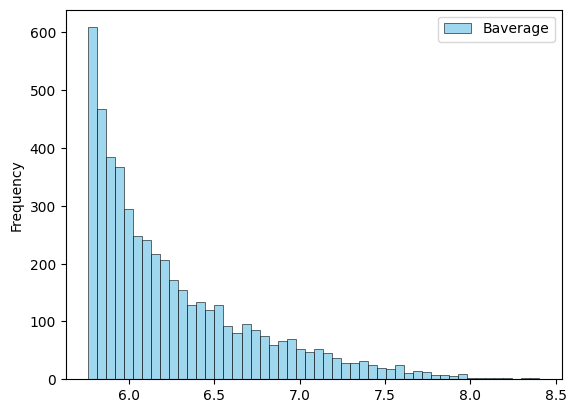

In [118]:
games_data_df.plot.hist(y='Baverage', bins=50, alpha=0.8, edgecolor='black', linewidth=0.5, color='skyblue')

<Axes: ylabel='Frequency'>

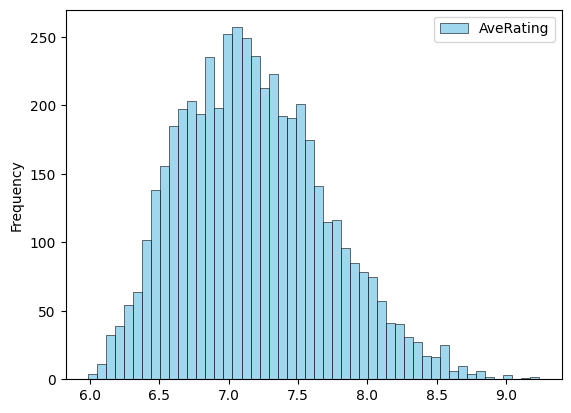

In [119]:
games_data_df.plot.hist(y='AveRating', bins=50, alpha=0.8, edgecolor='black', linewidth=0.5, color='skyblue')

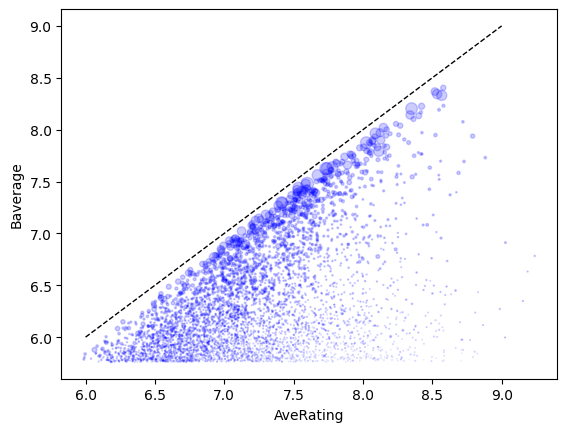

In [120]:
import matplotlib.pyplot as plt

size = games_data_df['NumPlays'] / 10000
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

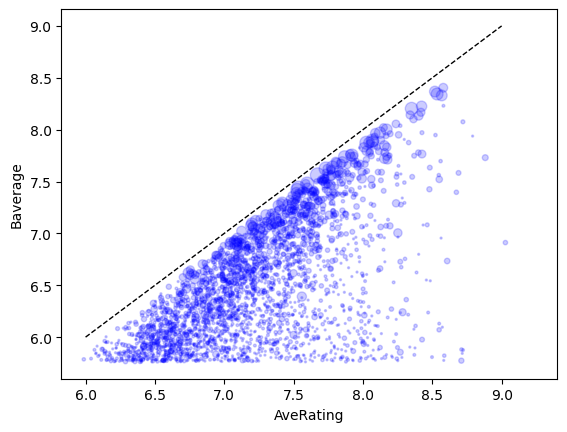

In [121]:
size = games_data_df['NumAwards'] * 2
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

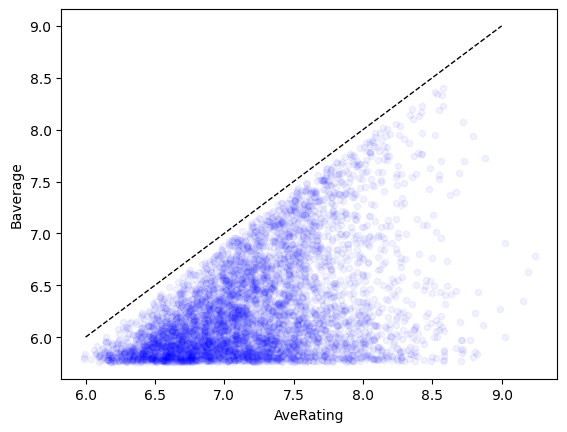

In [122]:
games_data_df.plot.scatter(x='AveRating', y='Baverage', alpha=0.05, color='blue')
# draw diagonal line
import matplotlib.pyplot as plt
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

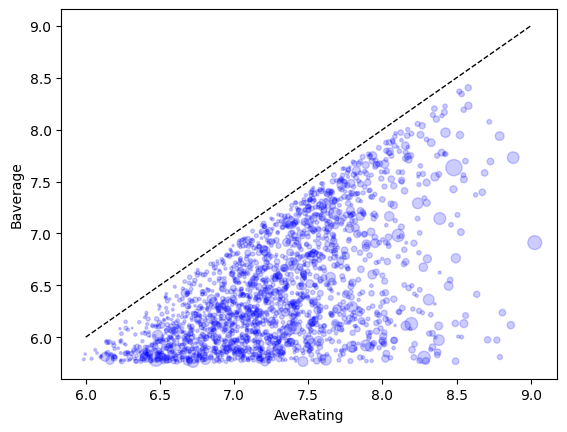

In [123]:
size = games_data_df['AmazonPrice'] / 5
games_data_df.plot.scatter(x='AveRating', y='Baverage', s=size, alpha=0.2, color='blue')
plt.plot([6, 9], [6, 9], color='black', linewidth=1, linestyle='--')
plt.show()

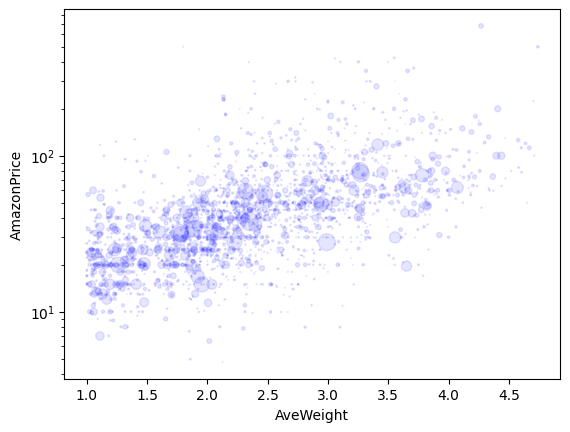

In [124]:
size = games_data_df['NumPlays'] / 5000
games_data_df.plot.scatter(x='AveWeight', y='AmazonPrice', s=size, alpha=0.1, color='blue')
# Draw a fit line
import numpy as np

x = games_data_df['AveWeight']
y = games_data_df['AmazonPrice']
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red')

plt.yscale('log')

In [154]:
# check if there are Nan or invalid values in Mechanics column
games_data_df.query('Mechanics == "Unknown"')

# Ok need to change "Unknown" to empty list
def create_empty_list_in_unknown(series):
    if series == 'Unknown':
        return []
    else:
        return series

games_data_df['Mechanics'] = games_data_df['Mechanics'].apply(create_empty_list_in_unknown)

In [155]:
games_data_df['Mechanics'].apply(lambda x: isinstance(x, list)).value_counts()

Mechanics
True    5000
Name: count, dtype: int64

In [127]:
all_mechanics = [ item for sublist in games_data_df['Mechanics'].tolist() for item in sublist ]
set(all_mechanics)

{'Acting',
 'Action / Event',
 'Action Drafting',
 'Action Points',
 'Action Queue',
 'Action Retrieval',
 'Action Timer',
 'Advantage Token',
 'Alliances',
 'Area Majority / Influence',
 'Area Movement',
 'Area-Impulse',
 'Auction / Bidding',
 'Auction Compensation',
 'Auction: Dexterity',
 'Auction: Dutch',
 'Auction: Dutch Priority',
 'Auction: English',
 'Auction: Fixed Placement',
 'Auction: Multiple Lot',
 'Auction: Once Around',
 'Auction: Sealed Bid',
 'Auction: Turn Order Until Pass',
 'Automatic Resource Growth',
 'Betting and Bluffing',
 'Bias',
 'Bids As Wagers',
 'Bingo',
 'Bribery',
 'Campaign / Battle Card Driven',
 'Card Play Conflict Resolution',
 'Catch the Leader',
 'Chaining',
 'Chit-Pull System',
 'Closed Drafting',
 'Closed Economy Auction',
 'Command Cards',
 'Commodity Speculation',
 'Communication Limits',
 'Connections',
 'Constrained Bidding',
 'Contracts',
 'Cooperative Game',
 'Crayon Rail System',
 'Critical Hits and Failures',
 'Cube Tower',
 'Deck Constr

In [156]:
games_data_df.to_json('games_data_df.json', orient='records')

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def fit_data(x, y, degree=1, fit_type='polynomial'):
    """
    Fits a model to the x, y data.

    Parameters:
        x (array-like): The x data.
        y (array-like): The y data.
        degree (int, optional): The degree of the polynomial for polynomial fitting.
        fit_type (str, optional): The type of fit ('polynomial' or 'exponential').

    Returns:
        function or tuple: Fitted polynomial function or exponential parameters.
    """
    if fit_type == 'polynomial':
        # Fit a polynomial model and return polynomial function
        coeffs = np.polyfit(x, y, degree)
        return np.poly1d(coeffs)
    elif fit_type == 'exponential':
        # Fit an exponential model and return coefficients (a, b)
        log_y = np.log(y)
        coeffs = np.polyfit(x, log_y, 1)  # Linear fit to log of y
        a = np.exp(coeffs[1])
        b = coeffs[0]
        return (a, b)


import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_data_with_fit(x, y, fit_result, x_col, y_col, sizes=None, fit_type='polynomial', log_scale=False):
    """
    Plots the original data and the fit line, with point size controlled by an optional sizes parameter.

    Parameters:
        x (array-like): The x data.
        y (array-like): The y data.
        fit_result (function or tuple): The result from fit_data, either a function or tuple of parameters.
        x_col (str): Name of the x variable for labeling.
        y_col (str): Name of the y variable for labeling.
        sizes (array-like, optional): Sizes of the scatter points.
        fit_type (str, optional): The type of fit ('polynomial' or 'exponential').
        log_scale (bool, optional): Whether to use a logarithmic scale for the y-axis.
    """
    # Default point size if not provided
    if sizes is None:
        sizes = 20

    plt.scatter(x, y, s=sizes, alpha=0.3, color='blue')
    
    # Sorting x for line plot
    sorted_x = np.sort(x)
    
    if fit_type == 'polynomial':
        # Apply polynomial fit result to sorted x
        plt.plot(sorted_x, fit_result(sorted_x), color='red', label=f'{fit_result.order}-degree polynomial')
    elif fit_type == 'exponential':
        a, b = fit_result
        # Apply exponential fit result to sorted x
        plt.plot(sorted_x, a * np.exp(b * sorted_x), color='red', label='Exponential fit')

    if log_scale:
        plt.yscale('log')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{fit_type.capitalize()} Fit: {x_col} vs {y_col}')
    plt.legend()
    plt.show()

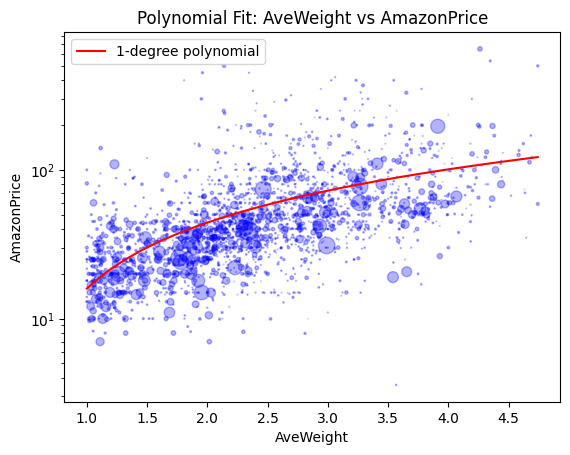

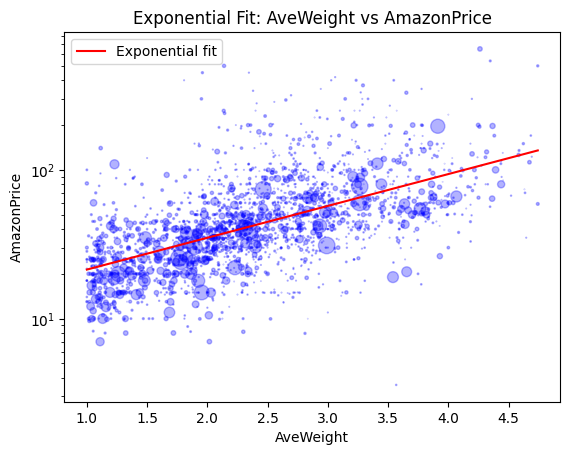

In [54]:
# Remove rows with missing AmazonPrice
filtered_price = games_data_df['AmazonPrice'].notnull()
filtered_price = games_data_df[filtered_price]

x = filtered_price['AveWeight']
y = filtered_price['AmazonPrice']
sizes = filtered_price['NumPlays'] / 5000

# Fit the data
fit_result = fit_data(x, y, degree=1, fit_type='polynomial')
# Plot the data and the fit
plot_data_with_fit(x, y, fit_result, 'AveWeight', 'AmazonPrice', sizes=sizes, fit_type='polynomial', log_scale=True)

# For exponential fit
fit_result_exp = fit_data(x, y, fit_type='exponential')
plot_data_with_fit(x, y, fit_result_exp, 'AveWeight', 'AmazonPrice', sizes=sizes, fit_type='exponential', log_scale=True)


In [49]:
sizes

0        25.3330
1        57.6298
2       103.1376
3        70.7790
4         8.4366
          ...   
5128      0.1130
5129      0.1114
5130      0.1398
5131      0.4962
5132      0.1008
Name: NumPlays, Length: 5000, dtype: float64

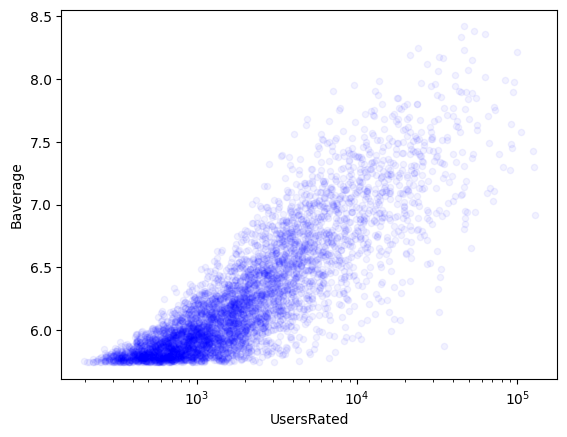

In [56]:
games_data_df.plot.scatter(x='UsersRated', y='Baverage', alpha=0.05, color='blue')
plt.xscale('log')

<Axes: xlabel='AmazonPrice', ylabel='Baverage'>

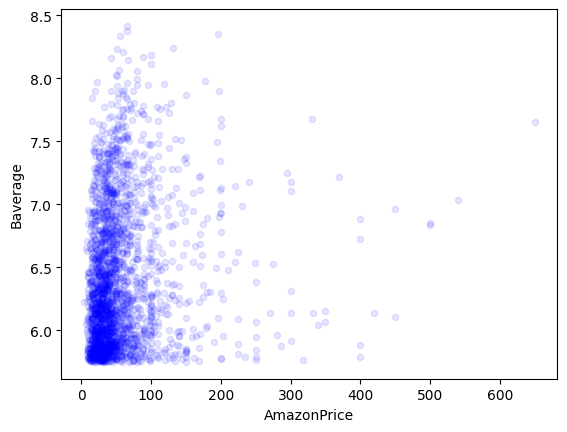

In [160]:
games_data_df.plot.scatter(x='AmazonPrice', y='Baverage', alpha=0.1, color='blue')

(0.0, 15.0)

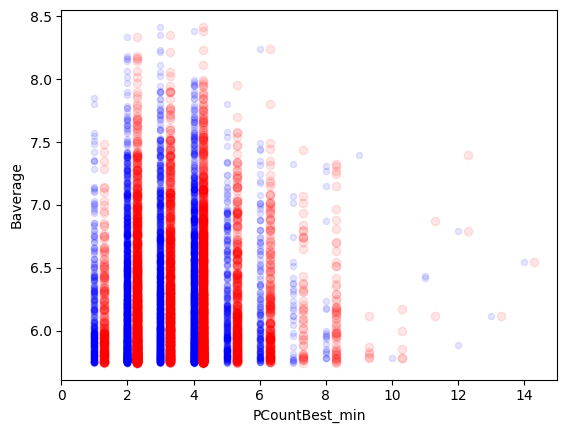

In [128]:
games_data_df.plot.scatter(x='PCountBest_min', y='Baverage', alpha=0.1, color='blue')
plt.scatter(games_data_df['PCountBest_max']+0.3, games_data_df['Baverage'], alpha=0.1, color='red')
plt.xlim(0, 15)

In [167]:
games_data_df.columns

Index(['Title', 'Link', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage',
       'StdDev', 'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards',
       'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min',
       'PCountBest_max', 'PCount_votes', 'MinPlayTime', 'MaxPlayTime',
       'Mechanics', 'GameCategory_1', 'RankCategory_1', 'ScoreCategory_1',
       'AmazonPrice', 'GameCategory_2', 'RankCategory_2', 'ScoreCategory_2',
       'GameCategory_3', 'RankCategory_3', 'ScoreCategory_3'],
      dtype='object')

In [1]:
(games_data_df
    .query('AveWeight < 1.5')
    .query('PCountBest_min >= 4')
    .query('PCountBest_max <= 6')
).to_csv('games_filtered.csv', index=False)

NameError: name 'games_data_df' is not defined

<Axes: xlabel='AveRating', ylabel='Baverage'>

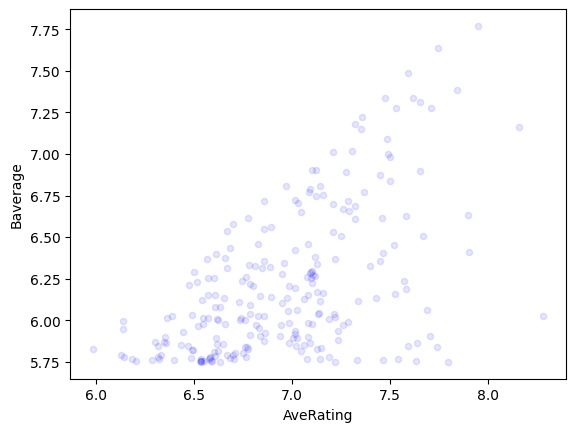

In [118]:
games_data_df.query('GameCategory_1 == "Abstract"').plot.scatter(x='AveRating', y='Baverage', alpha=0.1, color='blue')

# Predicting the Price in Amazon with the Features from BBG

In [132]:
(results.loc[:, ['Title', 'Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
    .head()
)

,Title,Rank,Year,UsersRated,AveRating,Baverage,AveWeight,NumWeights,NumPlays,NumAwards,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Category_1,AmazonPrice
0,Brass: Birmingham,1,2018,46043,8.59731,8.41456,3.8789,2229,124812,20,2,4.0,3,4.0,1106,60,120,Strategy,$63.48
1,Pandemic Legacy: Season 1,2,2015,53558,8.52713,8.37875,2.8316,1461,287053,30,2,4.0,4,4.0,863,60,60,Thematic,$71.97
2,Gloomhaven,3,2017,62246,8.58836,8.35218,3.9115,2566,513581,30,1,4.0,3,3.0,1542,60,120,Thematic,$285.49
3,Ark Nova,4,2021,43695,8.53514,8.33503,3.7606,2297,342465,36,1,3.0,2,2.0,1762,90,150,Strategy,$56.92
4,Twilight Imperium: Fourth Edition,5,2017,23849,8.60087,8.24171,4.319,1166,41631,2,3,6.0,6,6.0,572,240,480,Thematic,$131.99


In [133]:
# remove space (' ') if its the last character in the string
results['Category_1'] = results['Category_1'].apply(lambda x: x[:-1] if (isinstance(x, str) and x.endswith(' ')) else x)
# change "'" inside the string to avoid SQL errors
results['Title'] = results['Title'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
results['Category_1'] = results['Category_1'].apply(lambda x: x.replace("'", "") if isinstance(x, str) else x)
# If Catergory_1 is NaN, set it to 'Uncategorized'
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x != x else x)
results['Category_1'] = results['Category_1'].apply(lambda x: 'Uncategorized' if x == None else x)
# Remove $ sign from AmazonPrice
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: x.replace('$', '') if isinstance(x, str) else x)
# if not Unknown in AmazonPrice, convert to float
results['AmazonPrice'] = results['AmazonPrice'].apply(lambda x: float(x) if x != 'Unknown' else x)
# if not Unknown in Year, convert to int
results['Year'] = results['Year'].apply(lambda x: int(x) if x != 'Unknown' else x)
# These columns should contain integers: UsersRated, NumWeights, NumPlays, NumAwards, PCountRecomm_min, PCountRecomm_max, PCountBest_min, PCountBest_max, PCount_votes, MinPlayTime, MaxPlayTime
results['UsersRated'] = results['UsersRated'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumWeights'] = results['NumWeights'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumPlays'] = results['NumPlays'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['NumAwards'] = results['NumAwards'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_min'] = results['PCountRecomm_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountRecomm_max'] = results['PCountRecomm_max'].fillna(results['PCountRecomm_min'])
results['PCountRecomm_max'] = results['PCountRecomm_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
# If PCountRecomm_max == nan then set it to PCountRecomm_min
results['PCountBest_min'] = results['PCountBest_min'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCountBest_max'] = results['PCountBest_max'].fillna(results['PCountBest_min'])
results['PCountBest_max'] = results['PCountBest_max'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['PCount_votes'] = results['PCount_votes'].apply(lambda x: int(x) if x != 'Unknown' else x)
results['MinPlayTime'] = results['MinPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
results['MaxPlayTime'] = results['MaxPlayTime'].apply(lambda x: int(x) if x != 'NA' else x)
# These columns should contain floats: AveRating, Baverage, StdDev, AveWeight
results['AveRating'] = results['AveRating'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['Baverage'] = results['Baverage'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['StdDev'] = results['StdDev'].apply(lambda x: float(x) if x != 'Unknown' else x)
results['AveWeight'] = results['AveWeight'].apply(lambda x: float(x) if x != 'Unknown' else x)

In [134]:
# These columns will not be used for the model
results.drop(['RankCat_1', 'ScoreCat_1', 'Category_2', 'RankCat_2', 'ScoreCat_2', 'Category_3', 'RankCat_3', 'ScoreCat_3'], axis=1, inplace=True)

In [135]:
(results[results.isnull().any(axis=1)]
#    .Link
    .T
 )

""
Title
Link
Rank
Year
UsersRated
AveRating
Baverage
StdDev
AveWeight
NumWeights


In [136]:
results['Category_1'] = results['Category_1'].astype('category')

In [137]:
results.dtypes

Title                 object
Link                  object
Rank                   int64
Year                   int64
UsersRated             int64
AveRating            float64
Baverage             float64
StdDev               float64
AveWeight            float64
NumWeights             int64
NumPlays               int64
NumAwards              int64
PCountRecomm_min       int64
PCountRecomm_max       int64
PCountBest_min         int64
PCountBest_max         int64
PCount_votes           int64
MinPlayTime            int64
MaxPlayTime            int64
Mechanics             object
Category_1          category
AmazonPrice           object
dtype: object

In [138]:
(results
    .query('AmazonPrice != "Unknown"')
)

,Title,Link,Rank,Year,UsersRated,AveRating,Baverage,StdDev,AveWeight,NumWeights,...,PCountRecomm_min,PCountRecomm_max,PCountBest_min,PCountBest_max,PCount_votes,MinPlayTime,MaxPlayTime,Mechanics,Category_1,AmazonPrice
0,Brass: Birmingham,https://boardgamegeek.com/boardgame/224517/bra...,1,2018,46043,8.59731,8.41456,1.41606,3.8789,2229,...,2,4,3,4,1106,60,120,Hand Management\nIncome\nLoans\nMarket\nNetwor...,Strategy,63.48
1,Pandemic Legacy: Season 1,https://boardgamegeek.com/boardgame/161936/pan...,2,2015,53558,8.52713,8.37875,1.59840,2.8316,1461,...,2,4,4,4,863,60,60,Action Points\nCooperative Game\nHand Manageme...,Thematic,71.97
2,Gloomhaven,https://boardgamegeek.com/boardgame/174430/glo...,3,2017,62246,8.58836,8.35218,1.73928,3.9115,2566,...,1,4,3,3,1542,60,120,Action Queue\nAction Retrieval\nCampaign / Bat...,Thematic,285.49
3,Ark Nova,https://boardgamegeek.com/boardgame/342942/ark...,4,2021,43695,8.53514,8.33503,1.38399,3.7606,2297,...,1,3,2,2,1762,90,150,Action Queue\nEnd Game Bonuses\nGrid Coverage\...,Strategy,56.92
4,Twilight Imperium: Fourth Edition,https://boardgamegeek.com/boardgame/233078/twi...,5,2017,23849,8.60087,8.24171,1.62048,4.3190,1166,...,3,6,6,6,572,240,480,Action Drafting\nArea-Impulse\nDice Rolling\nF...,Thematic,131.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,Sequence,https://boardgamegeek.com/boardgame/2375/sequence,3302,1982,10556,6.12146,5.93070,1.49566,1.3147,502,...,2,4,3,4,107,10,30,Hand Management\nPattern Building\nTake That\n...,Family,14.97
3305,Valparaíso,https://boardgamegeek.com/boardgame/257058/val...,3306,2018,952,6.87959,5.92737,1.12636,2.8049,41,...,2,5,5,5,25,45,90,Action Queue\nKill Steal\nPoint to Point Movem...,Strategy,48.95
3307,Dungeons & Dragons: Rock Paper Wizard,https://boardgamegeek.com/boardgame/207062/dun...,3308,2016,1530,6.57288,5.93244,1.36025,1.3333,27,...,3,6,5,6,17,30,30,Simultaneous Action Selection\nTake That\n,Party,21.72
3310,The Blood of an Englishman,https://boardgamegeek.com/boardgame/206504/blo...,3311,2016,1496,6.54979,5.92681,1.23373,1.8261,23,...,2,2,2,2,10,20,30,Pattern Building\nVariable Player Powers\n,Family,16.19


In [155]:
data = (
    results
        .loc[:, ['Rank', 'Year', 'UsersRated', 'AveRating', 'Baverage', 
                'AveWeight', 'NumWeights', 'NumPlays', 'NumAwards', 
                'PCountRecomm_min', 'PCountRecomm_max', 'PCountBest_min', 'PCountBest_max', 'PCount_votes',
                'MinPlayTime', 'MaxPlayTime', 'Category_1', 'AmazonPrice']]
        .query('AmazonPrice != "Unknown"')
        .query('AmazonPrice < 200')
        .copy()
)

In [156]:
data.AmazonPrice.describe()

count     1695.00
unique     982.00
top         39.99
freq        31.00
Name: AmazonPrice, dtype: float64

In [160]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

features = data.columns[1:-1]

X = data[features]
y = data['AmazonPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBRegressor(objective='reg:squarederror', 
                     enable_categorical=True,
                     verbosity=0,
                     n_estimators=1000,
                     max_depth=10,
                     learning_rate=0.1,
                     subsample=0.9,
                     colsample_bytree=0.9,
                     reg_lambda=1,
                     reg_alpha=0,
                     gamma=0,
                     min_child_weight=1,)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

In [163]:
print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R^2: {model.score(X_test, y_test):.2f}')

Mean Squared Error: 937.38
Mean Absolute Error: 20.68
R^2: 0.30


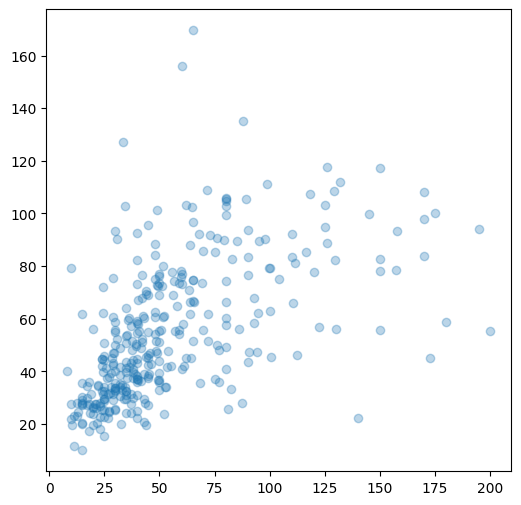

In [165]:
# plot true vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)